# Benchmarking

These are preliminaries benchmarks between different (Gaussian) Mixture packages. In fact `ExpectationMaximization.jl` deals with arbitrary mixture models (given the functions `log(dist)` and `fit_mle(dist, y[, w])`). `Sklearn` and `GaussianMixtures.jl` are specialized for Gaussian Mixtures. `mixtools` support several mixtures type.

In principle I should benchmark larger hidden state/latent/class `K`. Here it is only `K = 2`. The dimension also should be larger.
I tried to be as fair as possible with the benchmarks, but some packages do many things I am not certain to have completely avoided e.g. I want all benchmark to have same initial state, however `sklearn` tries to find good initial condition.

## Set up

In [1]:
using StableRNGs
using Distributions, LinearAlgebra
using BenchmarkTools, Test
using StatsPlots, LaTeXStrings

using ExpectationMaximization
using GaussianMixtures
using PythonCall, CondaPkg
using RCall

One could use `@rimport microbenchmark` to benchmark in R and `timeit = pyimport("timeit")` in Python to prevent a potential overhead time of using `RCall.jl` and `PythonCall.jl`, however I find them very hard to manipulate compare to `BenchmarkTools.jl`.

Set threads to 1 to be fair. (Note that `ExpectationMaximization.jl` is expected to have thread support at some point).

In [2]:
BLAS.set_num_threads(1)

Threads.nthreads()

1

Python threads

In [3]:
os = pyimport("os")
os.environ["OMP_NUM_THREADS"] = "1"

"1"

### R

For some reason this was not working from Julia.
```julia
R"""install.packages("mixtools", repos='http://cran.us.r-project.org')"""
```

In [4]:
@rimport mixtools # https://www.rdocumentation.org/packages/mixtools/versions/2.0.0
R_EM = mixtools.normalmixEM

RObject{ClosSxp}
function (x, lambda = NULL, mu = NULL, sigma = NULL, k = 2, mean.constr = NULL, 
    sd.constr = NULL, epsilon = 1e-08, maxit = 1000, maxrestarts = 20, 
    verb = FALSE, fast = FALSE, ECM = FALSE, arbmean = TRUE, 
    arbvar = TRUE) 
{
    warn <- options(warn = -1)
    x <- as.vector(x)
    tmp <- normalmix.init(x = x, lambda = lambda, mu = mu, s = sigma, 
        k = k, arbmean = arbmean, arbvar = arbvar)
    lambda <- tmp$lambda
    mu <- tmp$mu
    sigma <- tmp$s
    k <- tmp$k
    arbvar <- tmp$arbvar
    arbmean <- tmp$arbmean
    if (fast == TRUE && k == 2 && arbmean == TRUE) {
        a <- normalmixEM2comp(x, lambda = lambda[1], mu = mu, 
            sigsqrd = sigma^2, eps = epsilon, maxit = maxit, 
            verb = verb)
    }
    else {
        z <- parse.constraints(mean.constr, k = k, allsame = !arbmean)
        meancat <- z$category
        meanalpha <- z$alpha
        z <- parse.constraints(sd.constr, k = k, allsame = !arbvar)
        sdcat <- z$catego

In [5]:
function R_mixtools(y, mu, sigma, alpha, iters=100)
    K = length(mu)
    res = R_EM(y, k=K, lambda=alpha, mu=mu, sigma=sigma, maxit=iters, epsilon=1e-5)
    time = @belapsed $R_EM($y, k=$K, lambda=$alpha, mu=$mu, sigma=$sigma, maxit=$iters, epsilon=$1e-5)
    return time, res
end

R_mixtools (generic function with 2 methods)

### Python

To install and import `sklearn`.

Install scikit-learn
```julia
CondaPkg.add("scikit-learn"; channel="conda-forge")
```

In [6]:
np = pyimport("numpy")
sklearn = pyimport("sklearn.mixture") # scikit-learn 1.3.2
py_EM = sklearn.GaussianMixture

Python: <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

In [7]:
function py_sklearn(y, mu, sigma, alpha, iters=100; infos=0, verbose_interval=1, tol=1e-5)
    precisions_init = [inv(Diagonal(sigma .^ 2))[i, i] for i in eachindex(mu)]
    K = length(mu)
    Y = reshape(y, (length(y), 1))
    MU = reshape(mu, (length(mu), 1))
    invsigma2 = reshape(precisions_init, (length(precisions_init), 1))
    g₀ = py_EM(n_components=K, covariance_type="diag", weights_init=alpha, means_init=MU, precisions_init=invsigma2, max_iter=iters, warm_start=false, verbose=infos, verbose_interval=verbose_interval, tol=tol).fit
    g = g₀
    res = g(Y)
    time = @belapsed g($Y) setup=(g = $g₀)
    return time, res
end

py_sklearn (generic function with 2 methods)

`mixem` was removed from benchmark because to slow and numerically instable i.e. return `NaN`.

In [8]:
# mixem = pyimport("mixem")

Here was the code for `mixem`
py_mixemEM = mixem.

```julia
function py_mixem(y, mu, sigma, alpha, iters=100)
    K = length(mu)
    dists = [mixem.distribution.NormalDistribution(mu=mu[i], sigma=sigma[i]) for i in 1:K]
    return @belapsed $py_mixemEM($y, dists, initial_weights=alpha, max_iterations=iters, progress_callback = :none, tol=1e-5, tol_iters=1)
end
```

### `GaussianMixtures.jl`
Julia package specilized for Gaussian Mixtures. Not sure it is actively maintained (it works however).

In [9]:
function jl_GMM(y, mu, sigma, alpha, iters=100)
    gmm = GMM(length(mu), 1)  # initialize an empty GMM object
    # stick in our starting values
    gmm.μ[:, 1] .= mu
    gmm.Σ[:, 1] .= sigma
    gmm.w[:, 1] .= alpha

    # run em!
    res = copy(gmm)
    em!(res, y[:,:], nIter=iters)
    time = @belapsed $em!(g, $(y[:,:]), nIter=iters) setup=(g = copy($gmm))
    return time, res
end

jl_GMM (generic function with 2 methods)

### `ExpectationMaximization.jl`

In [10]:
function my_em(y, mu, sigma, alpha, iters=100)
    mix = MixtureModel([Normal(mu[i], sigma[i]) for i in eachindex(mu)], alpha)
    res = fit_mle(mix, y, maxiter=iters, atol=1e-5)
    time = @belapsed $fit_mle($mix, $y, maxiter=$iters, atol=$1e-5)
    return time, res
end

my_em (generic function with 2 methods)

## Test

In [11]:
Names = ["ExpectationMaximization.jl", "GaussianMixtureModel.jl", "mixtools.R", "Sklearn.py"] #, "mixem.py"]

4-element Vector{String}:
 "ExpectationMaximization.jl"
 "GaussianMixtureModel.jl"
 "mixtools.R"
 "Sklearn.py"

### True values

In [12]:
μ = [-4, 10]
σ = [2, 10]
α = [0.8, 0.2]
mi = MixtureModel([Normal(μ[i], σ[i]) for i in eachindex(μ)], α)

MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.8000): Normal{Float64}(μ=-4.0, σ=2.0)
components[2] (prior = 0.2000): Normal{Float64}(μ=10.0, σ=10.0)


### Guess

In [13]:
mu = [-1, 1]
sigma = [1, 1]
alpha = [0.5, 0.5]

iters = 8
NN = Int[500, 1000, 5000, 1e4, 5e4, 1e5, 5e5, 1e6, 2e6]

KK = [2]

d = Dict{String,Matrix}()
for key in Names
    d[key] = ones(length(NN), length(KK))
end

Note that the `Sklearn` is kinda supsect since it triggers(ed?) a warning regarding Kmean which I do not want to use.
I asked a question [here](https://github.com/scikit-learn/scikit-learn/discussions/25916)
Plus there seem to have a long compilation time

In [14]:
for j in eachindex(KK)
    K = KK[j]
    for i in eachindex(NN)
        n = NN[i]
        rtol = 2e-2
        rng = StableRNG(123)
        y = rand(rng, mi, n)
        @show n

        d["ExpectationMaximization.jl"][i, j], res_my = my_em(y, mu, sigma, alpha, iters)
        d["GaussianMixtureModel.jl"][i, j], res_gmm = jl_GMM(y, mu, sigma, alpha, iters)

        d["Sklearn.py"][i, j], res_sk = py_sklearn(y, mu, sigma, alpha, iters)

        # this seems to work just fine (just print an annoying warning about convergence that I could not remove)
        d["mixtools.R"][i, j], res_R = R_mixtools(y, mu, sigma, alpha, iters)

        # mixtools vs EM.jl
        @test mean.(res_my.components) ≈ res_R[3][1:K] rtol = rtol
        @test std.(res_my.components) ≈ res_R[4][1:K] rtol = rtol
        @test probs(res_my) ≈ res_R[2][1:K] rtol = rtol

        # mixtools vs py_sklearn
        @test vec(pyconvert(Matrix,res_sk.means_)) ≈ res_R[3][1:K] rtol = rtol
        @test sqrt.(vec(pyconvert(Matrix,res_sk.covariances_))) ≈ res_R[4][1:K] rtol = rtol
        @test pyconvert(Vector,res_sk.weights_) ≈ res_R[2][1:K] rtol = rtol

        # mixtools vs gmm.jl
        @test vec(res_gmm.μ) ≈  res_R[3][1:K] rtol = rtol
        @test sqrt.(vec(res_gmm.Σ)) ≈ res_R[4][1:K] rtol = rtol
        @test res_gmm.w ≈ res_R[2][1:K] rtol = rtol
    end
end

n = 500
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT! 
number of iterations= 8 
WARNING! NOT CONVERGENT

## Results

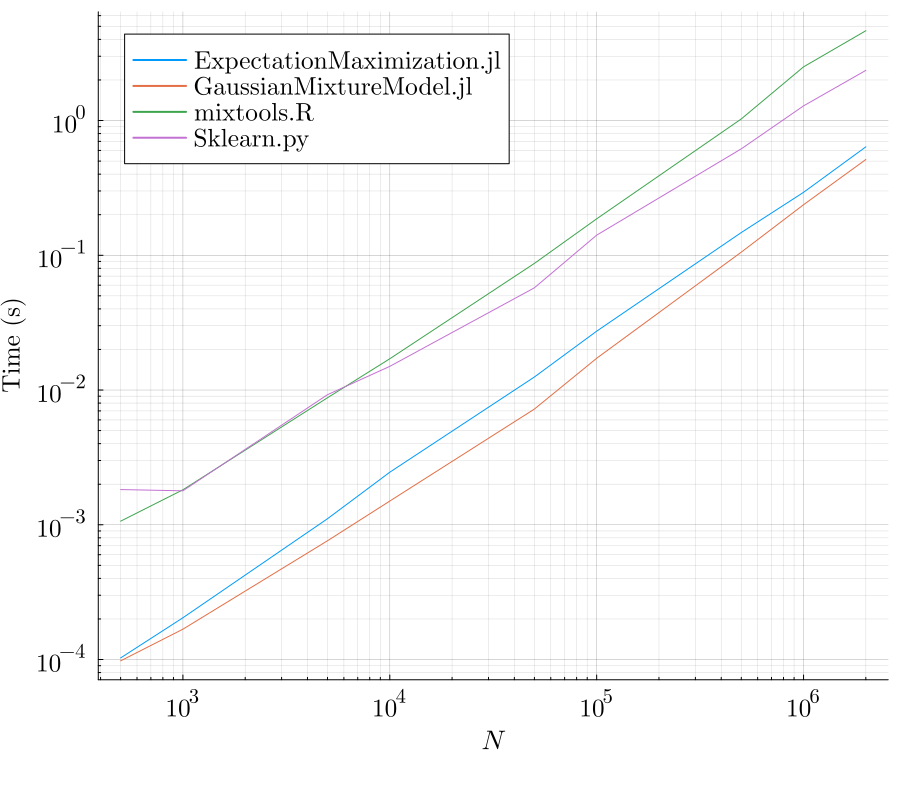

In [15]:
xNN = 10 .^ (2:6)
yti = 10 .^ (-4.0:1)
default(fontfamily="Computer Modern", linewidth=1, label=nothing)
begin
    K = 2
    plot(legend=:topleft, size=(900, 800), legendfontsize = 16, bottom_margin = 10Plots.mm, tickfontsize = 16, xlabelfontsize = 18, ylabelfontsize = 18)
    [plot!(NN, d[key][:, 1], label=key, c=na) for (na, key) in collect(enumerate(Names))]
    ylabel!("Time (s)", ylabelfontsize = 16)
    yaxis!(:log10)
    xaxis!(:log10)
    xlabel!(L"N")
    xticks!(xNN)
    yticks!(yti, minorticks=9, minorgrid=true, gridalpha=0.3, minorgridalpha=0.15)
end

In [16]:
savefig("timing_K_2.pdf")
savefig("timing_K_2.svg")

"C:\\Users\\metivier\\Dropbox\\PC (2)\\Documents\\dev\\ExpectationMaximization\\benchmarks\\timing_K_2.svg"

Ratio view

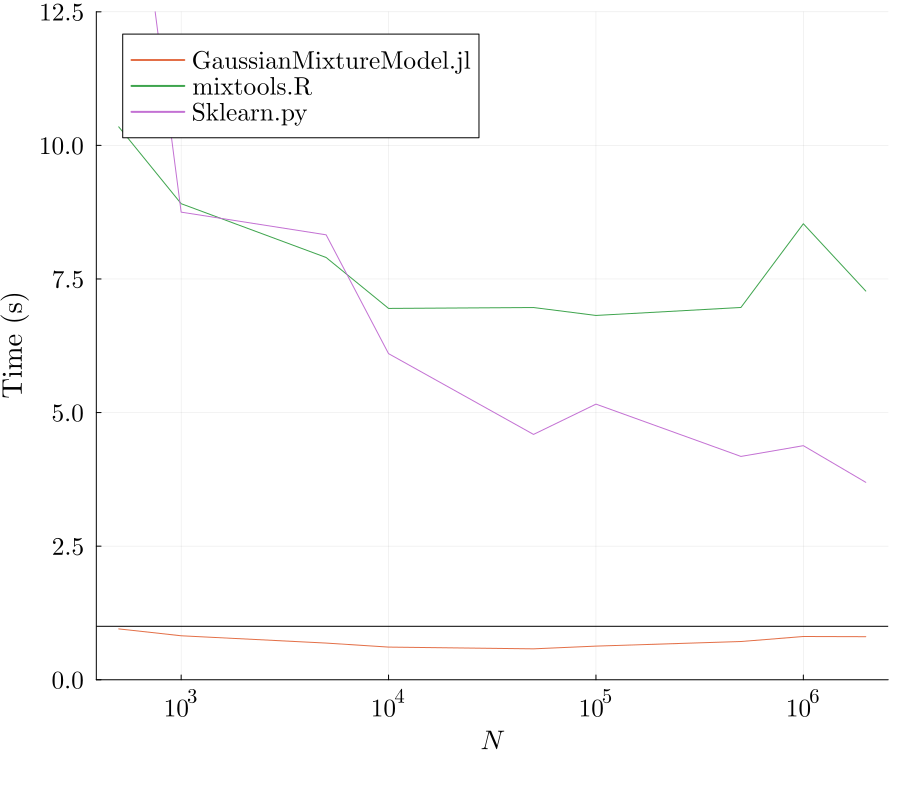

In [17]:
begin
    K = 2
    plot(legend=:topleft, size=(900, 800), legendfontsize = 16, bottom_margin = 10Plots.mm, tickfontsize = 16, xlabelfontsize = 18, ylabelfontsize = 18)
    [plot!(NN, d[key][:, 1]./d["ExpectationMaximization.jl"][:, 1], label=key, c=na+1) for (na, key) in collect(enumerate(Names[2:end]))]
    ylabel!("Time (s)")
    hline!([1], c=:black, label = :none)
        xaxis!(:log10)
    ylims!(0,12.5)
    xlabel!(L"N")
    xticks!(xNN)
end

In [18]:
savefig("timing_K_2_ratio.pdf")
savefig("timing_K_2_ratio.svg")

"C:\\Users\\metivier\\Dropbox\\PC (2)\\Documents\\dev\\ExpectationMaximization\\benchmarks\\timing_K_2_ratio.svg"

## Reproducibility

Computer and Julia

In [19]:
using InteractiveUtils
InteractiveUtils.versioninfo()

Julia Version 1.11.1
Commit 8f5b7ca12a (2024-10-16 10:53 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 28 × 13th Gen Intel(R) Core(TM) i7-13850HX
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, alderlake)
Threads: 1 default, 0 interactive, 1 GC (on 28 virtual cores)
Environment:
  JULIA_EDITOR = code
  JULIA_NUM_THREADS = 1


Julia packages

In [20]:
import Pkg; Pkg.status()

Status `C:\Users\metivier\Dropbox\PC (2)\Documents\dev\ExpectationMaximization\benchmarks\Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [992eb4ea] CondaPkg v0.2.23
  [31c24e10] Distributions v0.25.113
  [e1fe09cc] ExpectationMaximization v0.2.3 `C:\Users\metivier\.julia\dev\ExpectationMaximization`
  [cc18c42c] GaussianMixtures v0.3.10
  [b964fa9f] LaTeXStrings v1.4.0
  [6099a3de] PythonCall v0.9.23
  [6f49c342] RCall v0.14.6
  [860ef19b] StableRNGs v1.0.2
  [f3b207a7] StatsPlots v0.15.7
  [b77e0a4c] InteractiveUtils v1.11.0


Python

In [21]:
sys = pyimport("sys")
print("Python version:", sys.version)

Python version:3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:12:32) [MSC v.1929 64 bit (AMD64)]

Sklearn

In [22]:
CondaPkg.status()

CondaPkg Status c:\Users\metivier\Dropbox\PC (2)\Documents\dev\ExpectationMaximization\benchmarks\CondaPkg.toml
Environment
  c:\Users\metivier\Dropbox\PC (2)\Documents\dev\ExpectationMaximization\benchmarks\.CondaPkg\env
Packages
  scikit-learn v1.5.2 (channel=conda-forge)


R and packages

In [23]:
println(R"sessionInfo()")

RObject{VecSxp}
R version 4.4.1 (2024-06-14 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 22631)

Matrix products: default


locale:
[1] LC_COLLATE=French_France.1252  LC_CTYPE=French_France.1252   
[3] LC_MONETARY=French_France.1252 LC_NUMERIC=C                  
[5] LC_TIME=French_France.1252    

time zone: Europe/Paris
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] Matrix_1.7-1      gtable_0.3.6      jsonlite_1.8.9    dplyr_1.1.4      
 [5] compiler_4.4.1    tidyselect_1.2.1  tidyr_1.3.1       splines_4.4.1    
 [9] scales_1.3.0      fastmap_1.2.0     lattice_0.22-6    ggplot2_3.5.1    
[13] R6_2.5.1          generics_0.1.3    kernlab_0.9-33    htmlwidgets_1.6.4
[17] MASS_7.3-61       tibble_3.2.1      munsell_0.5.1     pillar_1.9.0     
[21] rlang_1.1.4       utf8_1.2.4        lazyeval_0.2.2    segmented_2.1-3  
[25] viridisLite

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*